This notebook contains code to generate plots of the CNN representations

In [1]:
from tqdm.notebook import tqdm
import time
import struct
import pickle
import os

import pandas as pd

import numpy as np

import gymnasium as gym
import miniworld

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import FastICA, PCA

from scipy.signal import convolve
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import matplotlib as mpl
from matplotlib.transforms import Affine2D

from stable_baselines3 import PPO
import torch
import gc

In [2]:
os.makedirs('../images/', exist_ok=True)

In [3]:
def collect_data(env, num_steps = 10000, mode="syst", noise=0.7):
    """
    Data should be required on "MiniWorld-StarMaze-v0" since this doesn't have a goal (i.e. box) in it.
    Args:
        num_steps (int): How many observations to gather
        mode (str): Which collection procedure to apply. Valid are "rand" for random, "systematic" for walking along the right wall,
                    "syst_rand" for a mixture of both
    """
    # Actions are 0 (turn left), 1 (turn right), 2 (move forward)
    observations = np.zeros((num_steps, 60, 80, 3))
    positions = np.zeros((num_steps, 3))
    actions = np.zeros((num_steps))
    directions = np.zeros((num_steps))
    i = 0
    pbar = tqdm(total=num_steps)
    while i < num_steps:
        match mode:
            case "rand":
                obs, acts, pos, rot = _rand_action(env)
            case "syst":
                obs, acts, pos, rot = _syst_action(env)
            case "syst_rand":
                obs, acts, pos, rot = _syst_rand_action(env, noise)
        if i+len(obs) > num_steps: # Potentially crop if num_steps is reached
            obs = obs[:num_steps-i]
            acts = acts[:num_steps-i]
            pos = pos[:num_steps-i]
            rot = rot[:num_steps-i]
        observations[i:i+len(obs)] = obs
        actions[i:i+len(acts)] = acts
        positions[i:i+len(pos)] = pos
        directions[i:i+len(rot)] = rot
        i += len(obs)
        pbar.update(len(obs))
    pbar.close()
    return observations, positions, actions, np.round(directions%(2*np.pi), 4) # Sort out multiples of direction beyond 2pi

def _rand_action(env):
    action = env.action_space.sample()
    obs, _, _, _, _ = env.step(action)
    return [obs], [action], [env.agent.pos], [env.agent.dir]

def _syst_action(env):
    # Walk alongside the right wall. This will just walk in circles if it doesn't find a wall!
    obs1, _, _, _, _ = env.step(1) # Turn right
    obs2, _, _, _, _ = env.step(2) # Move forward
    if np.array_equal(obs1, obs2): # If moving forward didn't work
        obs3, _, _, _, _ = env.step(0) # Turn back left
    else:
        return [obs1, obs2], [1,2], [env.agent.pos]*2, [env.agent.dir]*2
    obs4, _, _, _, _ = env.step(2) # Move forward
    if np.array_equal(obs3, obs4): # If moving forward didn't work
        obs5, _, _, _, _ = env.step(0) # Turn left
        return [obs5], [0], [env.agent.pos], [env.agent.dir]
    else:
        return [obs4], [2], [env.agent.pos], [env.agent.dir]

def _syst_rand_action(env, noise):
    if np.random.random() > noise:
        return _syst_action(env)
    else:
        return _rand_action(env)

In [4]:
def generate_top_view(env = "MiniWorld-StarMazeArm-v0", mode = "bw"):
    """
    Generates top view of the environment.
    Args:
        env (str): The environment
        mode (str): "bw" returns black white view, "orig" returns the original (including an agent placed somewhere)
    Returns:
        Tuple (extents, top_view), where extents is an array [min_x, max_x, min_z, max_z] of the view,
        and top_view is a shape (600, 800) array
    """
    tmp_env = gym.make(env, view="top", render_mode="rgb_array")
    tmp_env.reset()
    top_view = tmp_env.render()
    if mode in ["bw", "bg"]:
        top_view = np.equal(np.mean(top_view, axis=2), 176)
    if mode == "bg":
        top_view = np.where(top_view==1, 1, 0.2)
    # extent = np.array([(tmp_env.min_x - 1)*8/6, (tmp_env.max_x + 1)*8/6, tmp_env.min_z - 1, tmp_env.max_z + 1])
    extent = np.array([tmp_env.render_min_x, tmp_env.render_max_x, tmp_env.render_min_z, tmp_env.render_max_z])
    return extent, np.flip(top_view) # The view should be flipped to work correctly with imshow and the extents

In [5]:
def visualize_positions(positions, view, extents, line=True, colors=None, title=None, ax=None):
    """
    Creates a visualization of the agent's path. If colors==None, colors go from bright red (early positions) to dark red (late positions).
    Args:
        positions (np.ndarray): Array of shape (num_positions, 3) of positions
        view (np.ndarray): Array of shape (600, 800) or (600, 800, 3) that has a top view of the environment
        extents (np.ndarray): Array of shape (4) that specifies [min_x, max_x, min_z, max_z] of the view
        line (bool): Whether to plot a line plot or a scatter plot
        colors (np.ndarray): None, or array of shape (num_positions) which will be scaled to [-1,1] for a diverging color map
        title (str): A title for the plot
        ax (matplotlib.axes._axes.Axes): An axis object to plot into, if available
    """
    axis_was_none = False
    if ax is None:
        axis_was_none = True
        fig, ax = plt.subplots()
    if colors is None:
        colors = np.linspace(0.2, 1, len(positions))
    else:
        colors = np.where(colors >= 0, colors/np.max(colors), -colors/np.min(colors))
    ax.imshow(view, cmap="Greys", extent=extents, vmin=0)
    if line:
        points = np.array([positions[:,0], positions[:,2]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap="seismic", norm=Normalize(vmin=-1, vmax=1)) # norm is required because otherwise the colormap gets rescaled
        lc.set_array(colors)
        ax.add_collection(lc)
    else:
        ax.scatter(positions[:,0], positions[:,2], c=colors, cmap="seismic", norm=Normalize(vmin=-1, vmax=1), s=1, alpha=1)
    ax.set_title(title)
    if axis_was_none:
        plt.show()
        plt.close()

First, retrieve the names of runs (requires having run `wandb_to_csv.ipynb`) and check which are the best ones:

In [6]:
data = pd.read_csv("downloaded_runs.csv")

In [7]:
runs = data.groupby(["name"]).agg({"env_name": "max", "repl_mode": "max", "total_timesteps": "mean",
                            "global_step": "max", "rollout/ep_len_mean": "mean", "rollout/ep_rew_mean": "mean"})

In [8]:
runs

env_name repl_mode  \
name                                                             
autumn-galaxy-67                MiniWorld-WallGap-v0  cnn_comp   
autumn-spaceship-55             MiniWorld-WallGap-v0       sfa   
avid-energy-77           MiniWorld-StarMazeRandom-v0       sfa   
avid-serenity-50            MiniWorld-StarMazeArm-v0  cnn_comp   
blooming-butterfly-84    MiniWorld-StarMazeRandom-v0       pca   
...                                              ...       ...   
wise-firefly-96                 MiniWorld-WallGap-v0  cnn_comp   
wobbly-cloud-82                 MiniWorld-WallGap-v0       cnn   
woven-grass-119        MiniWorld-FourColoredRooms-v0       cnn   
youthful-plasma-99              MiniWorld-WallGap-v0       sfa   
zany-rain-90                MiniWorld-StarMazeArm-v0  cnn_comp   

                       total_timesteps  global_step  rollout/ep_len_mean  \
name                                                                       
autumn-galaxy-67             2000000.0    2000000.0           298.353496   
autumn-spaceship-55          2000000.0    2000000.0           299.348573   
avid-energy-77               2000000.0    2000000.0           364.733078   
avid-serenity-50             1000000.0    1000064.0          1458.365072   
blooming-butterfly-84        2000000.0    2000000.0           974.491251   
...                                ...          ...                  ...   
wise-firefly-96              2000000.0    2000000.0           298.752571   
wobbly-cloud-82              2000000.0    2000000.0           297.896252   
woven-grass-119              2000000.0    2000000.0           194.892906   
youthful-plasma-99           2000000.0    2000000.0           299.524010   
zany-rain-90                 1000000.0    1000064.0           945.478150   

                       rollout/ep_rew_mean  
name                                        
autumn-galaxy-67                  0.010795  
autumn-spaceship-55               0.005683  
avid-energy-77                    0.821103  
avid-serenity-50                  0.045389  
blooming-butterfly-84             0.418879  
...                                    ...  
wise-firefly-96                   0.009050  
wobbly-cloud-82                   0.013531  
woven-grass-119                   0.269462  
youthful-plasma-99                0.003565  
zany-rain-90                      0.408156  

[80 rows x 6 columns]

In [9]:
# For each combination of env_name and repl_mode, print the name of the best run and its mean episode length
for env_name in runs.env_name.unique():
    for repl_mode in runs.repl_mode.unique():
        subset = runs[(runs["env_name"] == env_name) & (runs["repl_mode"] == repl_mode)]
        idx = subset["rollout/ep_len_mean"].argmin()
        print(f"{'-> ' if repl_mode=='cnn' else ''}{env_name}, {repl_mode}: {subset.index[idx]} at {subset['rollout/ep_len_mean'].iloc[idx]}")

MiniWorld-WallGap-v0, cnn_comp: autumn-galaxy-67 at 298.3534959740472
MiniWorld-WallGap-v0, sfa: electric-sun-62 at 243.20904094474093
MiniWorld-WallGap-v0, pca: deft-water-57 at 213.75392579937733
-> MiniWorld-WallGap-v0, cnn: golden-wood-63 at 268.39057373074223
MiniWorld-StarMazeRandom-v0, cnn_comp: easy-eon-51 at 298.4405868274234
MiniWorld-StarMazeRandom-v0, sfa: avid-energy-77 at 364.73307806669527
MiniWorld-StarMazeRandom-v0, pca: blooming-butterfly-84 at 974.4912510829499
-> MiniWorld-StarMazeRandom-v0, cnn: silvery-serenity-79 at 343.58809119882113
MiniWorld-StarMazeArm-v0, cnn_comp: whole-music-49 at 524.640292826997
MiniWorld-StarMazeArm-v0, sfa: gallant-lake-94 at 133.08606546495363
MiniWorld-StarMazeArm-v0, pca: dashing-snowflake-68 at 915.119821849159
-> MiniWorld-StarMazeArm-v0, cnn: lunar-butterfly-36 at 433.79373232702875
MiniWorld-FourColoredRooms-v0, cnn_comp: true-yogurt-121 at 239.29553885393977
MiniWorld-FourColoredRooms-v0, sfa: fanciful-music-105 at 229.56409385

Now I'm hardcoding the model names for the runs that went best
- StarMaze: lunar-butterfly-36; 4insllqz
- WallGap: golden-wood-63; 1ud2s7as
- FourColoredRooms: sunny-frog-110; excauo0b

Then, analyse the CNN representations of those models. Use PCA to reduce them down from dimensionality 512.

In [10]:
env_names = ['MiniWorld-StarMaze-v0',
             'MiniWorld-WallGapEmpty-v0',
             'MiniWorld-FourColoredRoomsEmpty-v0',]
model_names = ["4insllqz", "1ud2s7as", "excauo0b"]
suffices = ['starmaze', 'wallgap', 'fourcoloredrooms']

  0%|          | 0/80000 [00:00<?, ?it/s]

  0%|          | 0/80000 [00:00<?, ?it/s]

  0%|          | 0/80000 [00:00<?, ?it/s]

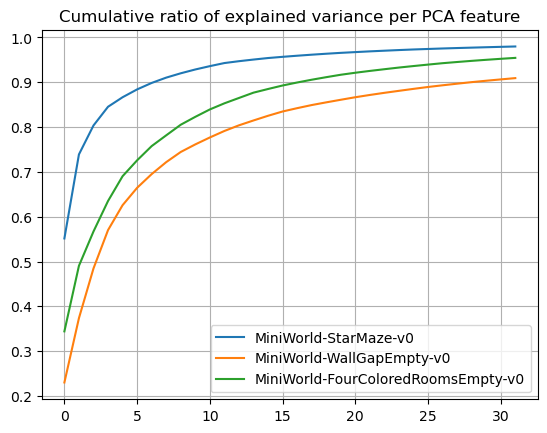

In [11]:
# Collect data
cnn_datasets = []
pos_datasets = []
rot_datasets = []
for env_name, model_name, suffix in zip(env_names, model_names, suffices):
    print(f"Collecting data for {env_name}")
    env = gym.make(env_name, view="agent", render_mode="rgb_array", max_episode_steps=100000)
    obs, info = env.reset()
    obs, pos, act, rot = collect_data(env, num_steps = 80000, mode = "rand")
    # Load model and get CNN representation:
    model = PPO.load(f"../scripts/.logs/models/{model_name}/model", device="cpu")
    obs_torch = torch.Tensor(np.moveaxis(obs, 3, 1)).to("cpu")
    del obs
    gc.collect()
    cnn_out_torch = model.policy.extract_features(obs_torch) 
    cnn_out = cnn_out_torch.detach().cpu().numpy()
    # Do dimensionality reduction through PCA to dim 32:
    pca_model = PCA(n_components=32)
    cnn_datasets.append(pca_model.fit_transform(cnn_out))
    plt.plot(np.cumsum(pca_model.explained_variance_ratio_), label=env_name)
    plt.title("Cumulative ratio of explained variance per PCA feature")
    plt.grid()
    plt.legend()
    pos_datasets.append(pos)
    rot_datasets.append(rot)
    del obs_torch
    del cnn_out_torch
    del cnn_out
    gc.collect()

In [12]:
fs = 16
plt.rcParams.update({
    'font.size': fs,
    'axes.titlesize': fs,
    'axes.labelsize': fs,
    'legend.fontsize': fs
})

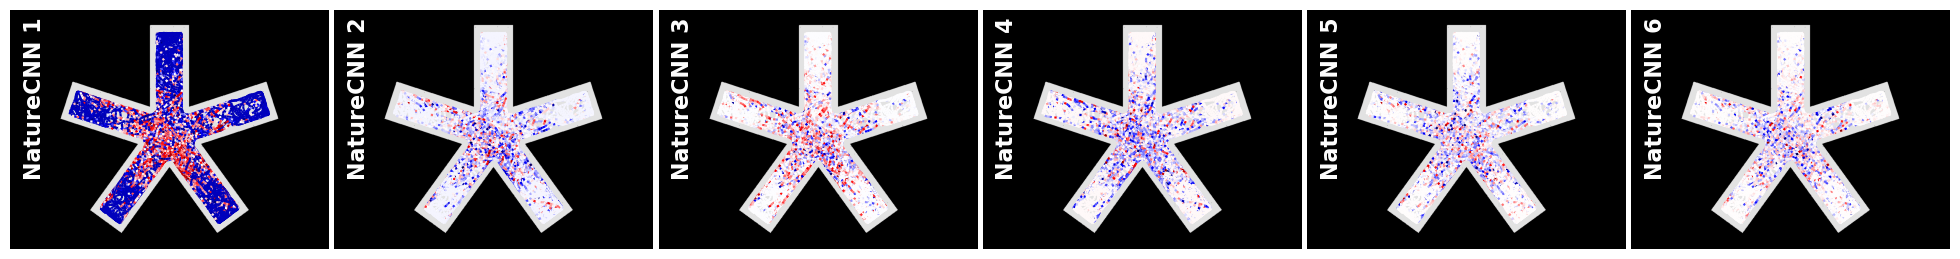

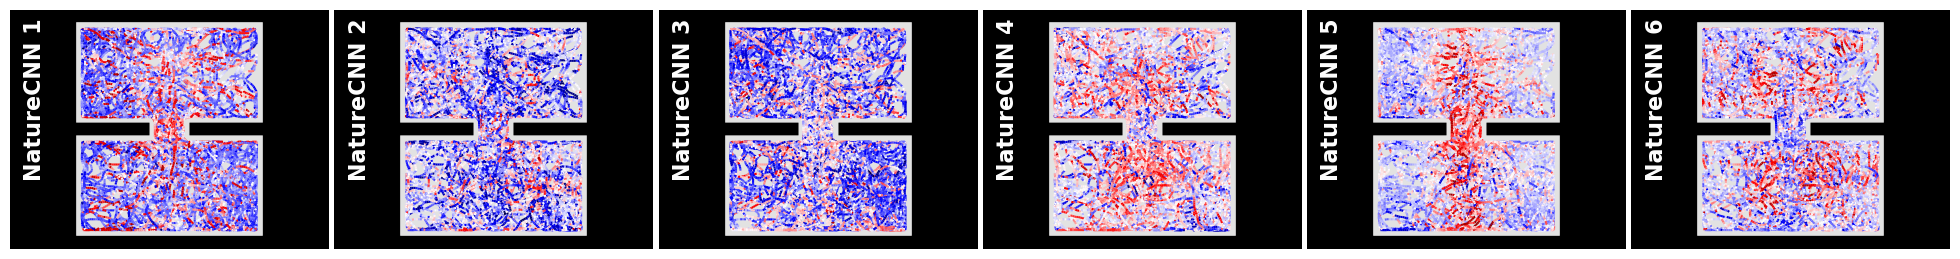

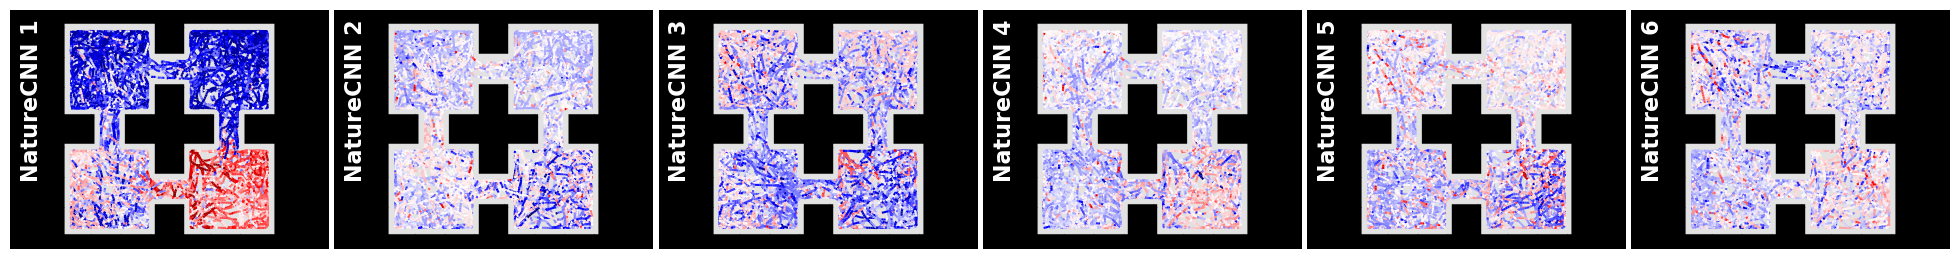

In [34]:
# Plot locations
for i, (env_name, suffix) in enumerate(zip(env_names, suffices)):
    cnn_data = cnn_datasets[i]
    pos_data = pos_datasets[i]
    fig, axes = plt.subplots(1, 6, figsize = (20,3.3))
    extents, view = generate_top_view(env = env_name, mode = "bg")
    for j in range(6):
        ax = axes[j]#[j//3][j%3]
        visualize_positions(pos_data,
                            view,
                            extents,
                            line=True,
                            colors=cnn_data[:,j],
                            ax=ax)
        ax.set_axis_off()
        match suffix:
            case "starmaze":
                x=-9
                y=-2.5
            case "wallgap":
                x=-11
                y=-3.5
            case "fourcoloredrooms":
                x=-10
                y=-3.2
                
        ax.text(x=x, y=y, s=f"NatureCNN {j+1}", c="w", rotation=90, fontsize=16, fontweight="bold")
    fig.tight_layout(h_pad=0.2, w_pad=0.2) # pad = 1.12
    #fig.savefig(f'../images/cnn_reps_{suffix}.svg', bbox_inches='tight', format = 'svg', dpi=300) # bbox_inches='tight'
    fig.savefig(f'../images/cnn_reps_{suffix}.png', bbox_inches='tight', format = 'png', dpi=100)
    fig.savefig(f'../images/cnn_reps_{suffix}.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

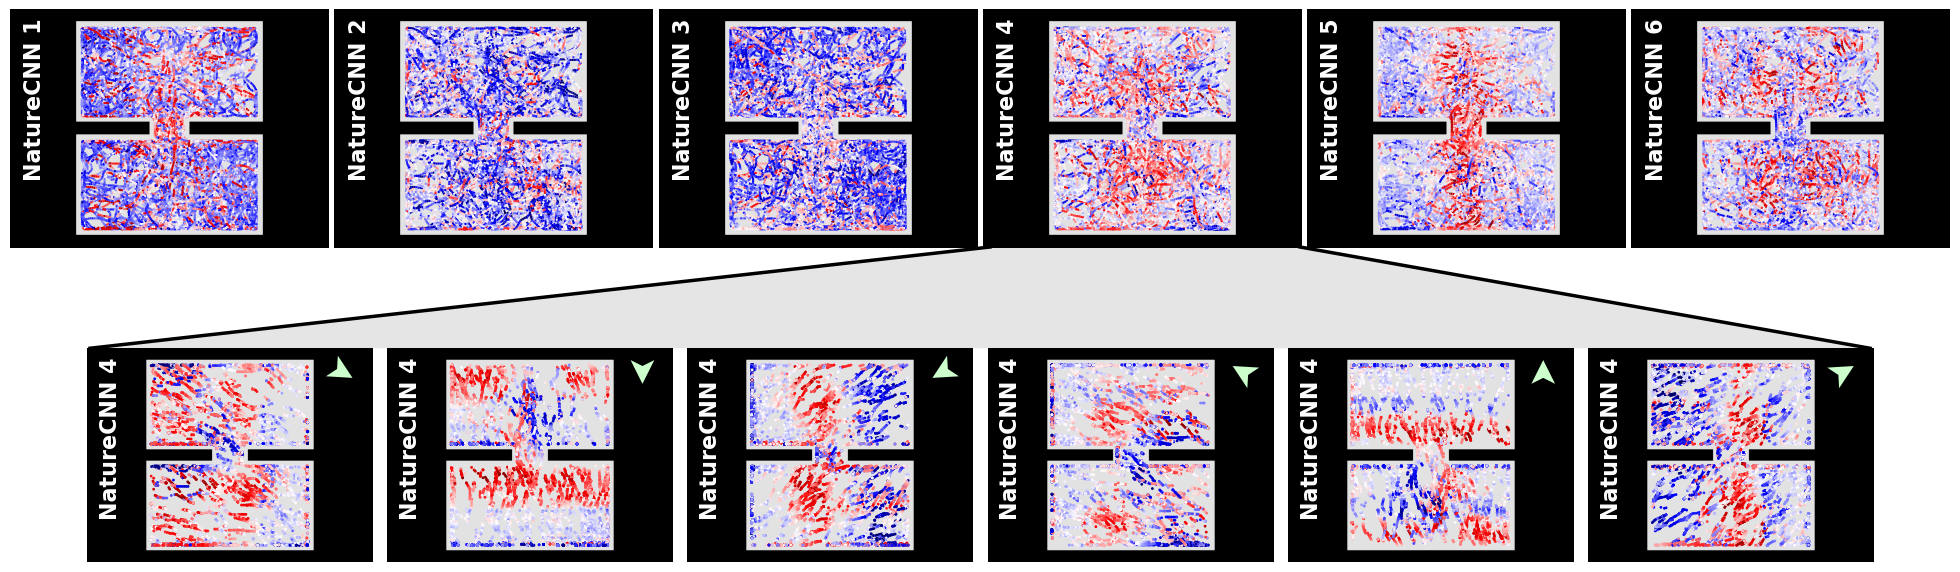

In [55]:
# Plot directions for WallGap|CNN 4
env_num = 1
cnn_feature_num = 3
# When adjusting cnn_feature_num, you must manually adjust zoom_coords for the zoom polygon to point to the right feature!

cnn_data = cnn_datasets[env_num]
pos_data = pos_datasets[env_num]
rot_data = rot_datasets[env_num]
fig, axes = plt.subplots(2, 6, figsize = (20,7.5), gridspec_kw = {'height_ratios':[2.4,1]})

extents, view = generate_top_view(env = env_names[env_num], mode = "bg")
arrow = np.array([[8.5,8], [10.5,7], [8.5,6], [9, 7]])
rot_factor = np.pi/3

for j in range(6):
    ax = axes[0][j]
    ax.set_axis_off()
    visualize_positions(pos_data,
                        view,
                        extents,
                        line=True,
                        colors=cnn_data[:,j],
                        ax=ax)
    x=-11
    y=-3.5
    ax.text(x=x, y=y, s=f"NatureCNN {j+1}", c="w", rotation=90, fontsize=16, fontweight="bold")

    ax = axes[1][j]
    ax.set_axis_off()
    idxs = np.where((rot_data > rot_factor*j) & (rot_data <= rot_factor*(j+1)))[0]
    positions = np.take(pos_data, idxs, axis=0)
    colors = np.take(cnn_data[:,cnn_feature_num], idxs, axis=0)
    visualize_positions(positions, view, extents, line=False, colors=colors, ax=ax)
    y = -5
    ax.text(x=x, y=y, s=f"NatureCNN {cnn_feature_num+1}", c="w", rotation=90, fontsize=16, fontweight="bold")

    rot_deg = -(rot_factor*j + rot_factor/2)*360/2/np.pi
    arrow_patch = mpl.patches.Polygon(arrow, transform=Affine2D().rotate_deg_around(*(9.5,7), rot_deg)+ax.transData, fc=(0.8,1,0.8),zorder=99)
    ax.add_patch(arrow_patch)
        
fig.tight_layout(h_pad=1, w_pad=0.2) # pad = 1.12

move_by = [0.03, 0.018, 0.006, -0.006, -0.018, -0.03]
for i in range(6):
    pos = axes[1, i].get_position()
    new_pos = [pos.x0+move_by[i], pos.y0, pos.width, pos.height]
    axes[1, i].set_position(new_pos)

zoom_offsets = [0, 0.177, 0, 0.505, 0, 0]
zoom_coords = np.array([[0.055,0.325], [zoom_offsets[cnn_feature_num],0.46], [zoom_offsets[cnn_feature_num]+0.155,0.46], [0.945,0.325]])
zoom = mpl.patches.Polygon(zoom_coords, fc=(0,0,0,0.1), ec=(0,0,0,0.4), linewidth=2.5, zorder=99)
polygon = mpl.patches.Polygon(zoom_coords, fc=(0,0,0,0.1), ec=(0,0,0,0), zorder=99) #linewidth=2.5
line1 = mpl.lines.Line2D(zoom_coords[0:2,0], zoom_coords[0:2,1], c=(0,0,0,1), linewidth=2.5, zorder=99)
line2 = mpl.lines.Line2D(zoom_coords[2:4,0], zoom_coords[2:4,1], c=(0,0,0,1), linewidth=2.5, zorder=99)
fig.add_artist(polygon)
fig.add_artist(line1)
fig.add_artist(line2)
#fig.savefig(f'../images/cnn_reps_{suffices[env_num]}_with_rot.svg', bbox_inches='tight', format = 'svg', dpi=300) # bbox_inches='tight'
fig.savefig(f'../images/cnn_reps_{suffices[env_num]}_with_rot.png', bbox_inches='tight', format = 'png', dpi=100)
fig.savefig(f'../images/cnn_reps_{suffices[env_num]}_with_rot.pdf', bbox_inches='tight')
plt.show()
plt.close()

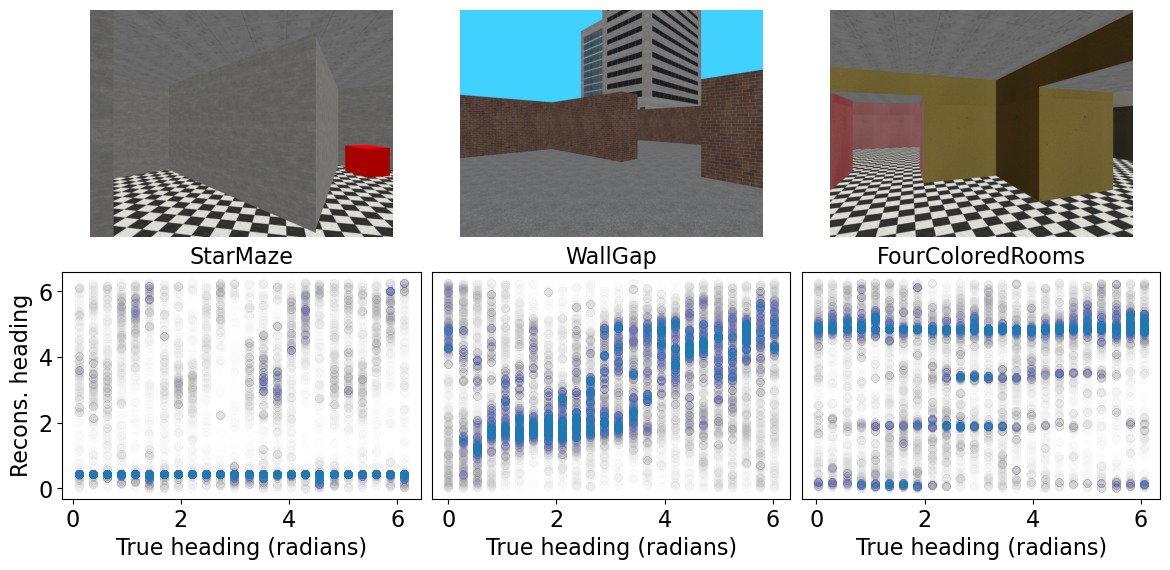

In [15]:
# Render high-res environment views and plot headings
n_train_subset = int(len(cnn_datasets[0])*0.5)

env_names = ['MiniWorld-StarMazeArm-v0',
             'MiniWorld-WallGapEmpty-v0',
             'MiniWorld-FourColoredRoomsEmpty-v0',]

fig, axes = plt.subplots(2, 3, figsize = (12,6))

for i, (env_name, suffix) in enumerate(zip(env_names, suffices)):
    ax = axes[0][i]
    env = gym.make(env_name, view="agent", render_mode="rgb_array", obs_width=10*80, obs_height=10*60)
    obs, info = env.reset()
    match suffix:
        case "starmaze":
            env.agent.pos = [-0.9492, 0, -1.0658]
            env.agent.dir = 0.2009
            title = "StarMaze"
        case "wallgap":
            env.agent.pos = [-3.6325, 0, -6.1611]
            env.agent.dir = 5.5
            title = "WallGap"
        case "fourcoloredrooms":
            env.agent.pos = [-6.1617, 0, -3.3271]
            env.agent.dir = -0.35
            title = "FourColoredRooms"
    obs = env.render()
    ax.imshow(obs)
    ax.set_axis_off()
    
    ax = axes[1][i]
    cnn_data = cnn_datasets[i]
    rot_data = rot_datasets[i]
    reg_cos = LinearRegression().fit(cnn_data[:n_train_subset],
                                     np.cos((rot_data[:n_train_subset])%(2*np.pi)-np.pi))
    reg_sin = LinearRegression().fit(cnn_data[:n_train_subset],
                                     np.sin((rot_data[:n_train_subset])%(2*np.pi)-np.pi))

    predicted_cos = reg_cos.predict(cnn_data[n_train_subset:])
    predicted_sin = reg_sin.predict(cnn_data[n_train_subset:])
    
    
    reconstructed_angles = np.arctan2(predicted_sin, predicted_cos)
    ax.scatter(rot_data[n_train_subset:], reconstructed_angles+np.pi, alpha=0.005)
    ax.set_xlabel("True heading (radians)")
    ax.set_title(title)
    if i==0:
        ax.set_ylabel("Recons. heading")
    else:
        ax.get_yaxis().set_visible(False)
    del env
fig.tight_layout(pad=1.12, h_pad=0.5, w_pad=0.3)
#fig.savefig(f'../images/renderings_and_heading_cnn.svg', format = 'svg', dpi=300)
fig.savefig(f'../images/renderings_and_heading_cnn.png', format = 'png', dpi=100)
fig.savefig(f'../images/renderings_and_heading_cnn.pdf')
plt.show()
plt.close()

In [16]:
fs = 20
plt.rcParams.update({
    'font.size': fs,
    'axes.titlesize': fs,
    'axes.labelsize': fs,
    'legend.fontsize': fs
})

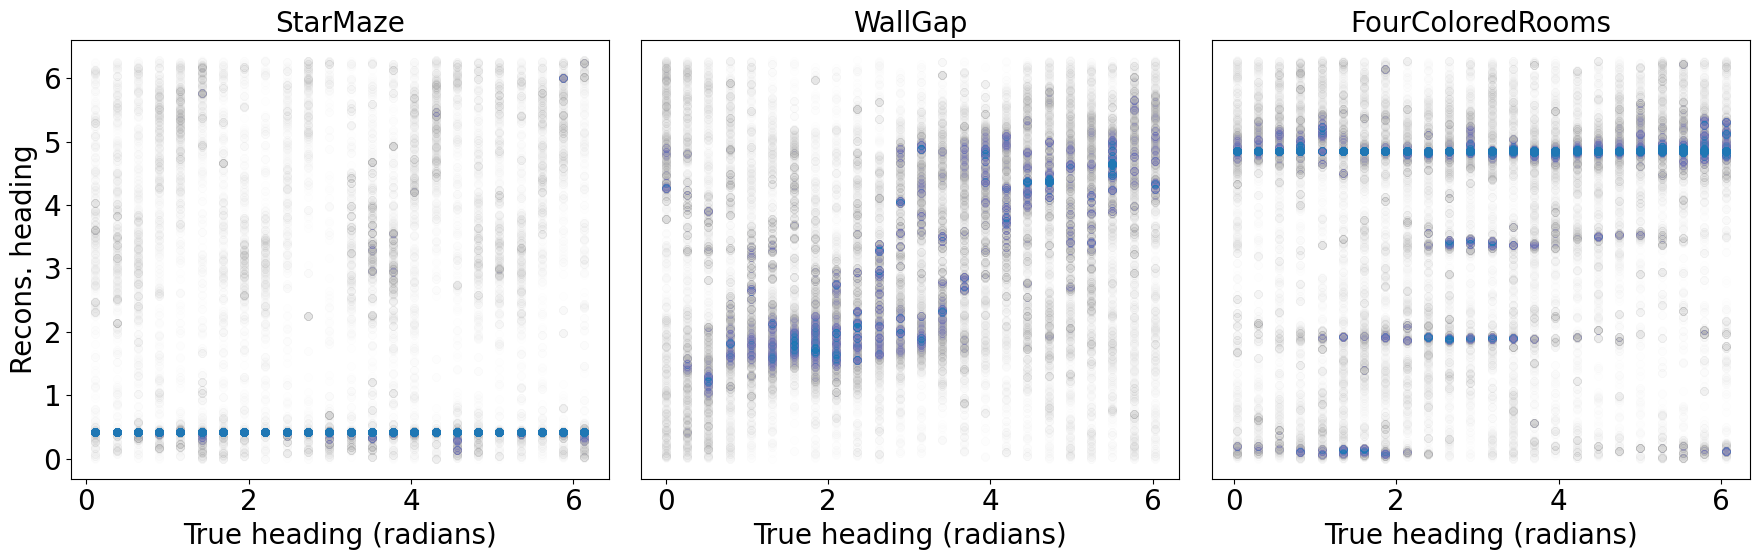

In [17]:
# Plot headings
n_train_subset = int(len(cnn_datasets[0])*0.5)

fig, axes = plt.subplots(1, 3, figsize = (18,6))

for i, (env_name, suffix) in enumerate(zip(env_names, suffices)):
    match suffix:
        case "starmaze":
            title = "StarMaze"
        case "wallgap":
            title = "WallGap"
        case "fourcoloredrooms":
            title = "FourColoredRooms"
    ax = axes[i]
    cnn_data = cnn_datasets[i]
    rot_data = rot_datasets[i]
    reg_cos = LinearRegression().fit(cnn_data[:n_train_subset],
                                     np.cos((rot_data[:n_train_subset])%(2*np.pi)-np.pi))
    reg_sin = LinearRegression().fit(cnn_data[:n_train_subset],
                                     np.sin((rot_data[:n_train_subset])%(2*np.pi)-np.pi))

    predicted_cos = reg_cos.predict(cnn_data[n_train_subset:])
    predicted_sin = reg_sin.predict(cnn_data[n_train_subset:])
    
    
    reconstructed_angles = np.arctan2(predicted_sin, predicted_cos)
    ax.scatter(rot_data[n_train_subset:], reconstructed_angles+np.pi, alpha=0.005)
    ax.set_xlabel("True heading (radians)")
    ax.set_title(title)
    if i==0:
        ax.set_ylabel("Recons. heading")
    else:
        ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=1, w_pad=1)
#fig.savefig(f'../images/cnn_reps_heading.svg', bbox_inches='tight', format = 'svg', dpi=300)
fig.savefig(f'../images/cnn_reps_heading.png', bbox_inches='tight', format = 'png', dpi=100)
fig.savefig(f'../images/cnn_reps_heading.pdf', bbox_inches='tight')
plt.show()
plt.close()